<a href="https://colab.research.google.com/github/Dmitry-Eremenko/home_work_3/blob/main/HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

import scipy
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns; 

# Домашнее задание по курсу анализа данных
Версия от 11.12.2021

Всего 50 баллов = 40 основных + 10 дополнительных

**Оценка**  = (Количество баллов за работу*2 + 20)/10

**Мягкий дедлайн: 18.12.2021  23:59**

**Жесткий дедлайн: 20.12.2021  8:59**

Присылать решение ссылкой на ваш **github** в телеграмм **@Aleron75** или на почту **milenkin.aa@phystech.edu**

**Автор:** Миленькин Александр

In [3]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head()

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет и, используя класстерный анализ, разбить пользователей на сегменты. Сделать выводы о причинах такой кластеризации.

# Чистка датасета (5 баллов)
* Есть ли дубли в данных? Если есть удалить.
* Найти и удалить выбросы по признаку `home_cost`. (Их не больше 15-х, не меньше 3-х)

In [4]:
#При помощи duplicated уберем все дубли, кроме первого вхождения
data = data[~data.index.duplicated(keep='first')]
data

,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
...,...,...,...,...,...,...,...,...,...
5495,1,1.0,1.212820e+07,1,9.0,Marketing,1.027045e+07,0.0,0.400123
5496,1,6.0,1.895356e+08,1,13.0,Entertainment,1.032767e+07,1.0,0.471274
5497,1,0.0,2.603326e+07,1,3.0,Executive,1.010075e+07,NaN,0.432856


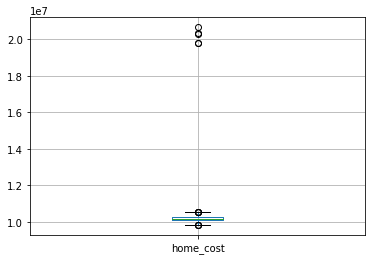

In [5]:
#Посмотрим на наличие выбросов
data.boxplot(column= ['home_cost'])

Выбросы есть, используем следующую функцию для избавления от них. 

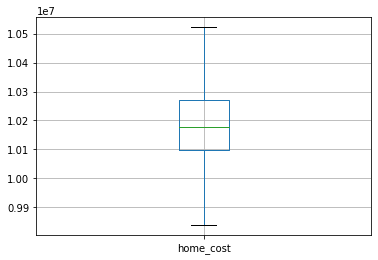

In [6]:
def remove_outlier(df, col_names):
    q1 = df[col_names].quantile(0.25)
    q3 = df[col_names].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df = df.loc[(df[col_names] > fence_low) & (df[col_names] < fence_high)]
    return df


q1 = data['home_cost'].quantile(0.001)
q3 = data['home_cost'].quantile(0.999)

#Удаляем выбросы при помощи функции
data = remove_outlier(data, 'home_cost')
# Проверяем на наличие вбросов снова, если останутся, то повторяем операцию. 
data.boxplot(column= ['home_cost'])

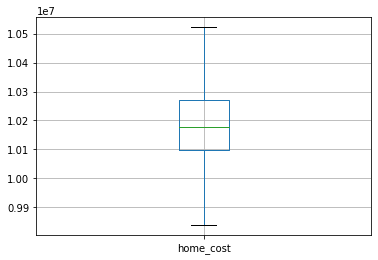

In [7]:
#Удаляем выбросы при помощи функции
data = remove_outlier(data, 'home_cost')
# Проверяем на наличие вбросов снова, если останутся, то повторяем операцию. 
data.boxplot(column= ['home_cost'])

Выбросов больше нет. 

# Проверка гипотез (15 баллов)

<div class="alert alert-info">

<b>Описание заданий раздела:</b>    
    
В этом разделел вам предстоит:
* Проверить предложенные утверждения визуально.
* Применить подходящий статистический критерий, чтобы окончательно доказать или опровергнуть гипотезы на снове этих данных.

<div class="alert alert-warning">
    
* Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?

Коэффициент корреляции пирсона:  0.23679743809292245
p-value:  8.17739347575853e-71


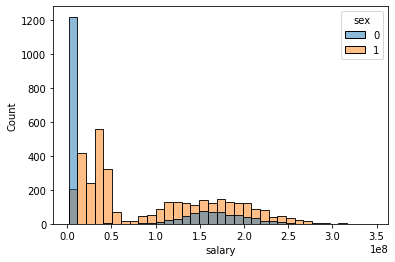

In [9]:
#Проверим гипотезу при помощи критерия пирсона

crit = stats.pearsonr(data['sex'],data['salary'])
print('Коэффициент корреляции пирсона: ', crit[0])
print('p-value: ', crit[1])

# Отрисуем гистограмму
x_ = data['salary']
hue_ = data['sex']
sns.histplot(data = data, x = data['salary'], bins = 35, alpha = 0.5, hue = data['sex'])


P - value значительно меньше 0.05, значит нулевая гипотеза отклоняется.
Средняя ЗП женщин не выше чем у мужчин.


<div class="alert alert-warning">
    
* Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?

p-value =  0.0


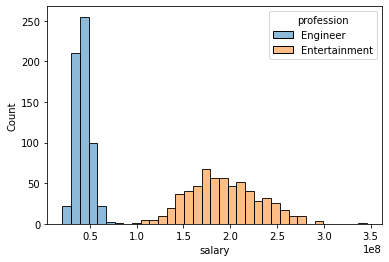

In [31]:
# делаем мини сет с выборкой по профессии 

Engineer = data[data['profession']=='Engineer']['salary']
Entertainment = data[data['profession']=='Entertainment']['salary']

# посчитаем статистически
t, p_value  = stats.ttest_ind(Engineer, Entertainment) 
print('p-value = ', p_value),

# нарисуем график
out =  data[(data['profession']=='Engineer')|(data['profession']=='Entertainment')]
sns.histplot(data = out, x = out['salary'], bins = 35, alpha = 0.5, hue = out['profession'])



p-value = 0.0 , а следовательно, корреляции не обнаружено. Нулевую гиппотезу отвергаем. 

<div class="alert alert-warning">
    
* Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?

p-value =  1.906709892215156e-114


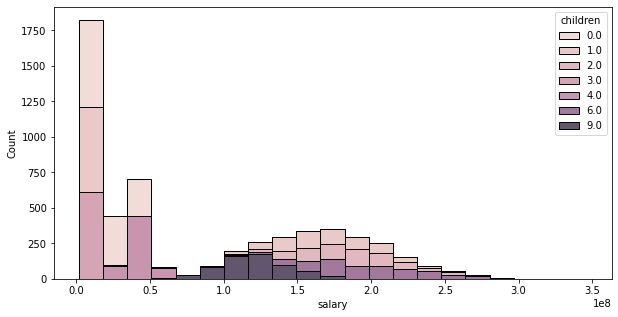

In [45]:
three_bolee = data[data['children'] > 3]['salary']
three_menee = data[data['children'] <= 3]['salary']

# посчитаем статистически
t, p_value  = stats.ttest_ind(three_bolee, three_menee) # Критерий Стьюдента (t-test)
print('p-value = ', p_value)


#нарисуем график
plt.figure(figsize=(10, 5)) 
sns.histplot(data = out, x = data['salary'],  hue = data['children'], multiple="stack", )

p-value =  1.906709892215156e-114, отклоняем нулевую гипотезу. В среднем больше зарабатювают те, у кого детей <= 3.

<div class="alert alert-warning">
    
* Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?

p-value =  7.269892973343168e-22


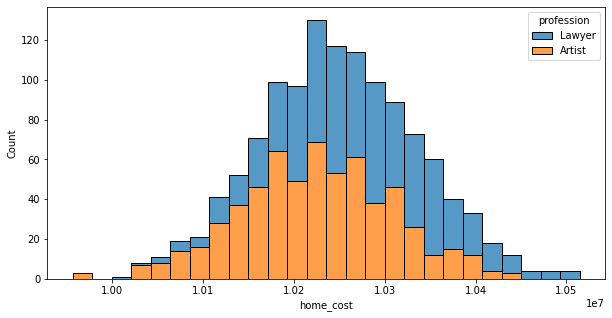

In [48]:
# делаем мини сет с выборкой по профессии 
Artist_HomeCost = data[data['profession'] =='Artist']['home_cost']
Lawyer_HomeCost = data[data['profession'] =='Lawyer']['home_cost']

# посчитаем статистически
t, p_value  = stats.ttest_ind(Artist_HomeCost, Lawyer_HomeCost)
print('p-value = ', p_value)

#нарисуем график
out =  data[(data['profession']=='Artist')|(data['profession']=='Lawyer')]
plt.figure(figsize=(10, 5)) 
sns.histplot(data = out, x = out['home_cost'],  hue = out['profession'], multiple="stack", )


p-value =  7.269892973343168e-22. Отвергаем нулевую гипотезу, дома адвокатов в среднем дороже домов артистов. 

<div class="alert alert-warning">
    
* Прада ли, что недвижимость у бывавших в браке в среднем дороже, чем у не бывавших в браке?

p-value =  4.801333497906116e-149


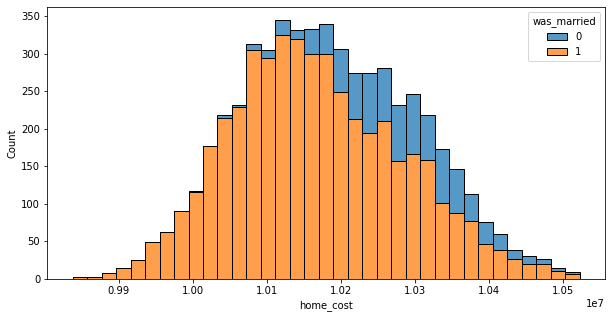

In [53]:
# делаем мини сет с выборкой по параметрам
married = data[data['was_married'] == 1]['home_cost']
alone = data[data['was_married'] == 0]['home_cost']


# посчитаем статистически
t, p_value  = stats.ttest_ind(married, alone) 
print('p-value = ', p_value)

#нарисуем график
out =  data[(data['profession']=='Artist')|(data['profession']=='Lawyer')]
plt.figure(figsize=(10, 5)) 
sns.histplot(data = data, x = data['home_cost'],  hue = data['was_married'], multiple="stack")

p-value =  4.801333497906116e-149. Отвергаем нулевую гипотезу, стоимость жилья не женатых в среднем выше. 

<div class="alert alert-warning">
    
* Прада ли, что мужчины в среднем чаще бывают в браке, чем женщины?

**Подсказка** - воспользуйтесь критерием хи-квадрат из библиотеки scipy

In [ ]:
# YOUR CODE

# Гипотезы при множественном тестировании (10 баллов)

In [ ]:
# Подсказка: 
# - дисперсионнай анализ  f_oneway()
# - Крускал Уоллиса

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Homemaker**, **Marketing**, **Healthcare** и **Executive** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием. 

p_value = 0.0


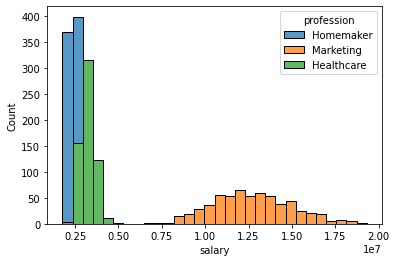

In [62]:
# делаем мини сет с выборкой по параметрам
homemaker = data[data['profession'] =='Homemaker']['salary']
marketing = data[data['profession'] =='Marketing']['salary']
healthcare = data[data['profession'] =='Healthcare']['salary']


#Дисперсионный анализ f_oneway()
F, pvalue= stats.f_oneway(homemaker, marketing, healthcare)  
print('p_value =', pvalue)

#нарисуем график
sub_data =  data[(data['profession']=='Homemaker')|(data['profession']=='Marketing')|(data['profession']=='Healthcare')]
sns.histplot(sub_data, x='salary', hue ='profession', bins=30, multiple="stack")

Корреляции нет, гипотезу отвергаем. Зарплаты по выбраным профессиям отличаются. 

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Doctor**, **Entertainment** и **Lawyer** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием. 

p_value = 3.0782539431452083e-33


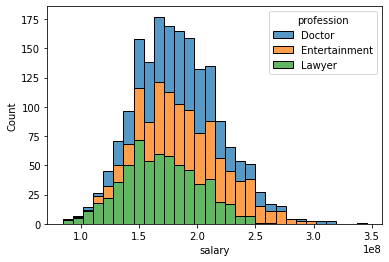

In [64]:
# делаем мини сет с выборкой по параметрам
doc = data[data['profession'] =='Doctor']['salary']
entertainment = data[data['profession'] =='Entertainment']['salary']
lawyer = data[data['profession'] =='Lawyer']['salary']


#Дисперсионный анализ f_oneway()
F, pvalue= stats.f_oneway(doc, entertainment, lawyer)  
print('p_value =', pvalue)

#нарисуем график
sub_data =  data[(data['profession']=='Doctor')|(data['profession']=='Entertainment')|(data['profession']=='Lawyer')]
sns.histplot(sub_data, x='salary', hue ='profession', bins=30, multiple="stack")

Нет, зарплаты по выбраным профессиям различаются. 

# Регрессионный Анализ (20 баллов)

Взглянем от чего зависит уровень счастья

In [66]:
import statsmodels.formula.api as smf

# Рекомендации: 
# Используйте библиотку statsmodels для оценки вклада каждого фактора
# Выведения отчета о модели - model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<div class="alert alert-warning">
    
Выполните следующие задания и на основе результатов ответьте на вопросы:

* Постройте регрессионную модель зависимости уровня счастья от приведенных факторов (was_married, children, salary, sex, age, home_cost)
* Существует ли связь между уровнем счастья и зарплатой?

* Насколько сильны эти отношения?

* Как факт брака способствуют стоимости недвижимости?

* Зная влияние каждого фактора, можем ли мы предсказать уровень счастья?

* Постройте график зависимостей целевой переменной от приведенных числовых факторов. 
    
* Какие признаки не влияют на уровень счастья? (стат. значимость)
    
* Какой признак самый сильный?
    
* Постройте график остатков. Всю ли информацию смогла извлечь ваша модель из данных?

* Наблюдается ли гетероскедастичность в остатках?
    
* Есть ли в данных автокоррелированность?  

In [72]:
#нормализация данных  RobustScaler 
from sklearn.preprocessing import RobustScaler 
RobustScaler = RobustScaler()

chisl = ['children', 'salary', 'age', 'home_cost']
new_data = RobustScaler.fit_transform(data[chisl].values)
new_data
data[chisl] = new_data

In [74]:
model = smf.ols('happyness ~ was_married + children + salary + sex + age + home_cost', data=data)
out = model.fit()
print(out.summary())

                            OLS Regression Results                            
Dep. Variable:              happyness   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     868.7
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:12:38   Log-Likelihood:                 4341.6
No. Observations:                5488   AIC:                            -8669.
Df Residuals:                    5481   BIC:                            -8623.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3263      0.006     57.402      

**ОТЫЕТЫ**

* Существует ли связь между уровнем счастья и зарплатой?  
Существует

* Насколько сильны эти отношения?  
Коэффициент связи = 0.0188 

* Как факт брака способствуют стоимости недвижимости?  
Стоимость недвижимости в браке ниже, чем вне брака. 

* Зная влияние каждого фактора, можем ли мы предсказать уровень счастья?  
Можем, но не очень точно R-squared = 0.487. Зависимость не полностью описана. 
    
* Какие признаки не влияют на уровень счастья? (стат. значимость)  
home_cost, pvalue = 0.248 > 0.05
    
* Какой признак самый сильный?  
Intercept       0.3695 

* Есть ли в данных автокоррелированность?   
Durbin-Watson:                   2.065, следовательно, присутствует. 
 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


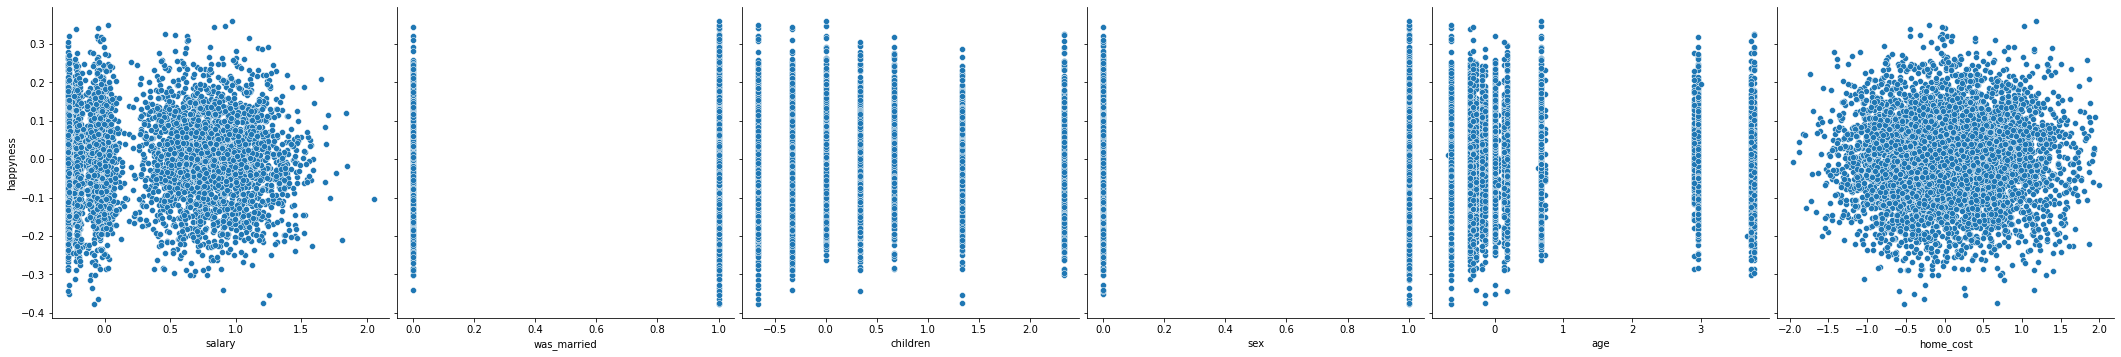

In [79]:
data['happyness'] = res.resid

sns.pairplot(
    data, 
    y_vars='happyness', 
    x_vars=['salary', 'was_married', 'children', 'sex', 'age', 'home_cost'], 
    size=5,    
);

# Дополнительные баллы (+10 баллов)
* Аккуратный и понятный код **+5 баллов**
* Присутствуют лаконичные и понятные комментарии **+5 балов**